# Step 1: Installation

Simply run ```pip install pyzx``` because we intent to use PyZX as a Python module for use in other projects.

In [2]:
!pip install pyzx

     |████████████████████████████████| 174kB 7.1MB/s 


Let’s start by importing the library

In [3]:
 import pyzx as zx

Then we can create a new random <b>Clifford circuit</b> and visualise it.

( Clifford circuits – i.e. circuits composed of only CNOT, Hadamard, and phase gates )

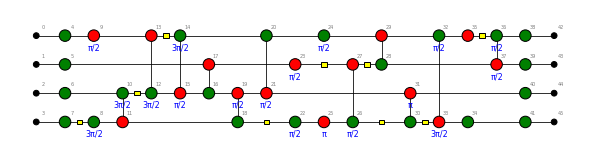

In [4]:
qubit_amount = 4
depth = 15
circ = zx.generate.cliffords(qubit_amount, depth)
zx.draw_matplotlib(circ,labels=True,h_edge_draw='box')


<b>Depth</b>: 
- The circuit depth is the length of the longest path from the input to the output, moving forward in time along qubit wires.
- The stopping points on the path are the gates, the allowed paths that must be considered can enter and exit those gates on any input / output, and the length is the number of jumps from each gate to the next gates along the path.

This will require some understanding of [ZX Calculus](https://en.wikipedia.org/wiki/ZX-calculus).

The green and red nodes represent Z- and X-phase gates respectively, the yellow boxes are Hadamard gates, and the vertical lines going between two different colored nodes are CNOT gates.

Internally this circuit is represented as a graph:

In [5]:
print(circ)
print("All edges are: ", list(circ.edges()))
print("\nThe neighbors of a particular vertex: ", list(circ.neighbors(24)))


Graph(46 vertices, 53 edges)
All edges are:  [(0, 4), (1, 5), (2, 6), (3, 7), (4, 9), (5, 17), (6, 10), (7, 8), (8, 11), (9, 13), (10, 11), (10, 12), (11, 18), (12, 13), (12, 15), (13, 14), (14, 15), (14, 20), (15, 16), (16, 17), (16, 19), (17, 23), (18, 19), (18, 22), (19, 21), (20, 21), (20, 24), (21, 31), (22, 25), (23, 27), (24, 29), (25, 26), (26, 27), (26, 30), (27, 28), (28, 29), (28, 37), (29, 32), (30, 31), (30, 33), (31, 40), (32, 33), (32, 35), (33, 34), (34, 41), (35, 36), (36, 37), (36, 38), (37, 39), (38, 42), (39, 43), (40, 44), (41, 45)]

The neighbors of a particular vertex:  [20, 29]



Using this graph representation we can use the rules of the [ZX-calculus](https://en.wikipedia.org/wiki/ZX-calculus) to simplify it:

In [6]:
g = circ.copy()
zx.clifford_simp(g)

2

Let us use one of the built-in ZX-diagram simplification routines on this ZX-diagram:

The command ```zx.clifford_simp(g)``` simplifies the diagram

In [7]:
g.normalize()
zx.draw(g)

The command ```g.normalize()``` Reposition nodes horizontally to look nicer. Something like below,
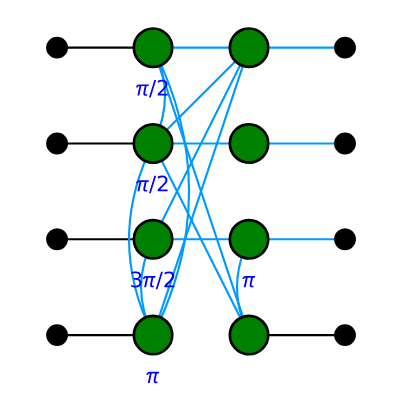

The blue lines represent edges that have a Hadamard gate on them.

Let's try to see in a bit more detail what goes into rewriting this circuit.

In [8]:

from ipywidgets import widgets
from IPython.display import display, Markdown

from pyzx.simplify import clifford_iter

graph = circ.copy()
graphs = [zx.draw_matplotlib(graph)]
names = ["start"]
for gs, n in clifford_iter(graph):
    graphs.append(zx.draw_matplotlib(gs))
    names.append(n)
zx.drawing.pack_circuit_nf(gs,'grg')
graphs.append(zx.draw_matplotlib(gs))
names.append("reposition")

def plotter(rewrite):
    display(Markdown("Rewrite step: " + names[rewrite]))
    display(graphs[rewrite])

w = widgets.interactive(plotter, rewrite=(0,len(graphs)-1))
slider = w.children[0]
slider.layout.width = "{!s}px".format(min(800,50*len(graphs)))
output = w.children[-1]
output.layout.height = "{!s}px".format(200+qubit_amount*20)
slider.value = 0
w

interactive(children=(IntSlider(value=0, description='rewrite', layout=Layout(width='800px'), max=15), Output(…

As you can see, the first few steps are spider fusion, where adjacent <b>red</b> nodes and adjacent <b>green</b> nodes are fused together (and their phases added). The next step is to convert all red nodes to green nodes by changing regular edges to hadamard edges.

Now come the steps that do most of the work. These steps are a round of pivots followed by local complementations and then a round of pivots again. The local complementation rules looks for green nodes with a phase of $\frac\pi2$ or $\frac{3\pi}2$. By doing a local complementation on this node we can remove the node from the graph. This process is done until no more suitable candidates are found. A pivot consists of a series of three local complementations that is done on two neighboring vertices that have a zero or $\pi$ phase. A pivot move allows us to remove these two nodes.

Finally we do a round of identity simplification which removes phaseless nodes that are connected to precisely two neighbors.

<b>Note</b>: Depending on the circuit that was generated, any of these steps might not have been done.

Even though int the finla stage the graph is a lot compacter than the one we started out with, it no longer looks like a circuit. To fix this we need to be clever and extract a circuit from the ZX-diagram:

In [9]:
circ2 = g.copy()
circ2.normalize()
circ2 = zx.extract_circuit(circ2)
zx.draw(circ2)

To verify that this circuit (circ2) is equal to the original circuit (cirq), we can transform them into <b>numpy tensors</b> and compare these tensors for equality:

In [12]:
t1 = circ.to_tensor()
t2 = circ2.to_tensor()
zx.compare_tensors(t1,t2,preserve_scalar=False)

False

```zx.compare_tensors(t1,t2,preserve_scalar=False)``` This checks whether t1 and t2 are equal up to some number: <b>t1 == z*t2 for some complex number z


We can represent the circuit in one of several quantum circuit description languages, such as that of <b>QUIPPER</b> ( basically assembly language code for Quantum Computers ):

In [13]:

print(circ2.to_quipper())

Inputs: 0:Qbit, 1:Qbit, 2:Qbit, 3:Qbit
QGate["not"](3) with controls=[+2] with nocontrol
QGate["not"](2) with controls=[+3] with nocontrol
QGate["not"](3) with controls=[+2] with nocontrol
QGate["not"](1) with controls=[+0] with nocontrol
QGate["not"](0) with controls=[+1] with nocontrol
QGate["not"](1) with controls=[+0] with nocontrol
QGate["H"](3) with nocontrol
QGate["H"](1) with nocontrol
QGate["H"](2) with nocontrol
QGate["Z"](2) with controls=[+1] with nocontrol
QRot["exp(-i%Z)",2.356194490192345](1)
QGate["H"](3) with nocontrol
QGate["H"](0) with nocontrol
QGate["H"](1) with nocontrol
QGate["Z"](3) with controls=[+2] with nocontrol
QGate["Z"](2) with controls=[+1] with nocontrol
QGate["Z"](2) with controls=[+0] with nocontrol
QRot["exp(-i%Z)",1.5707963267948966](2)
QGate["H"](2) with nocontrol
QGate["Z"](3) with controls=[+2] with nocontrol
QRot["exp(-i%Z)",2.356194490192345](3)
QGate["H"](3) with nocontrol
QGate["not"](1) with controls=[+3] with nocontrol
QRot["exp(-i%Z)",2.35

Same thing can be done with more complicated circuits like Clifford+T circuit.

Optimizing random circuits is of course not very useful, so in later stages optimization on a predefined circuit would be focused upon ✌